This notebook provides the code to apply the trained models in a specific health region 

In [1]:
import numpy as np 
import pandas as pd 
import preprocess_data as prep
import matplotlib.pyplot as plt
from keras.models import load_model
from models import make_predictions

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


In [3]:
STATE = 'MG'

state_to_code = {'RJ': 33, 'ES': 32, 'PR': 41, 'CE': 23, 'MA': 21,
                 'MG': 31, 'SC': 42, 'PE': 26, 'PB': 25, 'RN': 24,
                 'PI': 22, 'AL': 27, 'SE': 28, 'SP': 35, 'RS': 43,
                 'PA': 15, 'AP': 16, 'RR': 14, 'RO': 11, 'AM': 13,
                 'AC': 12, 'MT': 51, 'MS': 50, 'GO': 52, 'TO': 17,
                 'DF': 53, 'BA': 29}

df = prep.load_cases_data()
df = df.loc[df.uf == STATE]
df = prep.load_cases_data()
df = df.loc[df.uf == STATE]

df_clima = prep.load_climate_data()

df_clima = df_clima.loc[df_clima.geocode.astype(str).str[:2] == str(state_to_code[STATE])]

df_end = df.merge(df_clima, left_on = ['date', 'epiweek', 'geocode'], right_on = ['date', 'epiweek', 'geocode'])

df_end.date = pd.to_datetime(df_end.date)

df_end.set_index('date', inplace = True)

enso = prep.load_sea_indicators()
columns_to_normalize = ['casos', 'temp_med', 'temp_amp', 'rel_humid_med', 'precip_tot', 'enso', 'iod', 'pdo']


### Carregue o modelo salvo e o ano associado com o modelo salvo:

In [4]:
model_name = 'bi_lstm'
year = 2022
model = load_model(f'./saved_models/region_model_{STATE}_{year}_{model_name}.keras')

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (4, 52, 19)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (4, 52, 128)           │       151,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (4, 52, 128)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (4, 52, 128)           │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (4, 52, 128)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (4, 128)               │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (4, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (4, 52)                │         6,708 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,264,286 (4.82 MB)

 Trainable params: 421,428 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 842,858 (3.22 MB)

None


### Defina o ano de teste e a macrorregião:

In [5]:
test_year = 2022
region = 31016

In [6]:
dates = prep.gen_forecast_dates(test_year)

list_of_enso_indicators = ['enso', 'iod', 'pdo']

indicators = [item for item in list_of_enso_indicators if item in columns_to_normalize]
 
predicted = np.zeros((1,52,100))

df_w = prep.aggregate_data_clima(df_end, region, column = 'regional_geocode')

data = df_w.merge(enso[indicators], left_index = True, right_index = True)

data = data.dropna()

X_train, y_train, norm_values = prep.get_train_data(data.loc[data.year < test_year], columns_to_normalize= columns_to_normalize)

X_test, y_test = prep.get_test_data(norm_values, data, test_year, columns_to_normalize)

df_preds = make_predictions(model, X_test, norm_values, dates = dates)


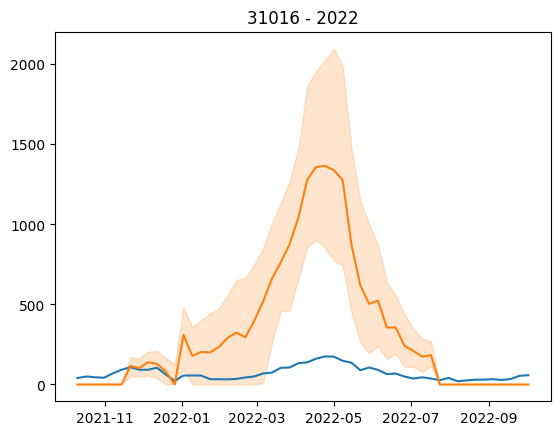

In [7]:
fig, ax = plt.subplots()

ax.plot(df_preds.dates, y_test[0]*norm_values['casos'], label = 'Data')

ax.plot(df_preds.dates, df_preds.preds, label = 'preds')

ax.fill_between( df_preds.dates, df_preds.lower, df_preds.upper, color = 'tab:orange', alpha = 0.2)

ax.set_title(f'{region} - {test_year}')

plt.show()